In [1]:
## imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime

In [2]:
## observe the data
filepath = r"C:\Projects\Deep Learning Academy\PerimeterX\Analysts_test1.csv"
data = pd.read_csv(filepath)
print(data.head(5))
print(data.shape)


                f0_                                          ua_server  \
0  1486400318059000  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...   
1  1486400339589000  Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...   
2  1486400331881000  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_5)...   
3  1486400420303000  Mozilla/5.0 (X11; Linux x86_64; rv:47.0) Gecko...   
4  1486400314265000  Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:4...   

        socket_ip    path  
0  216.107.163.79  /login  
1     50.67.4.172  /login  
2   75.138.200.57  /login  
3   106.184.6.187  /login  
4  24.214.241.129  /login  
(301983, 4)


In [3]:
# The data is with a shape of (301983,4)
# remove columns that have only one unique value - these columns are not meaningful
unique_cols = data.apply(pd.Series.nunique)
cols_to_remove = [col for ind, col in enumerate(unique_cols.index) if unique_cols[ind] == 1]
data.drop(cols_to_remove, axis=1, inplace=True)
print(data.columns)


Index(['f0_', 'ua_server', 'socket_ip'], dtype='object')


In [4]:
# The column "path" was removed - had only one unique value "login". All rows are login attempts
## The f0_ column looks like epoch timestamps. We will convert to date times and sort values
data['f0_'] = data["f0_"].apply(lambda x: datetime.datetime.fromtimestamp(x // 1000000))
data = data.sort_values(by="f0_")


Text(0.5,1,'Number of login attempts per minute')

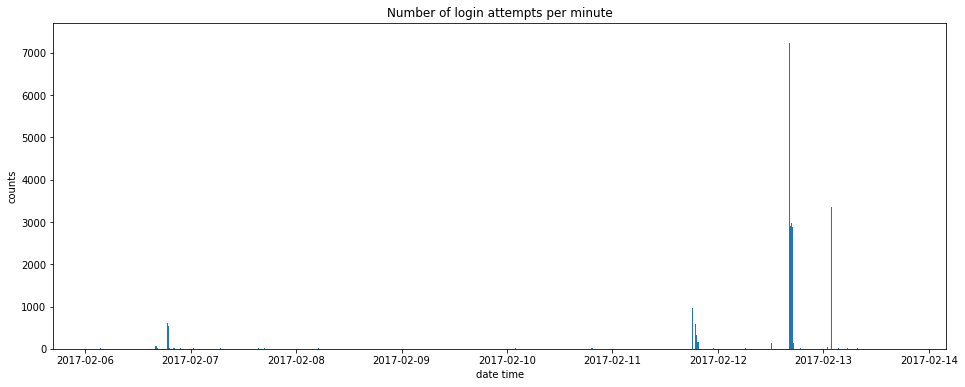

In [10]:
# we will draw a histogram of the number of login every minute in the data
num_minutes = int(np.round((data["f0_"].iloc[-1] - data["f0_"].iloc[0]).total_seconds()/60))
plt.figure(figsize=(16, 6))
plt.hist(data["f0_"], num_minutes)
plt.xlabel("date time")
plt.ylabel("counts")
plt.title("Number of login attempts per minute")


In [11]:
# it clearly looks from the histogram that there are times at which there are much more login attempts
## we will find a threshold on the number of login attempts per minute
bin_range = pd.date_range(data["f0_"].iloc[0], data["f0_"].iloc[-1], freq="1min")
f0_hist, _  = pd.cut(data["f0_"], bins=bin_range, include_lowest=True, right=False, retbins=True)
f0_hist = f0_hist.value_counts()
f0_pctile_per_minute = f0_hist.describe(percentiles=np.arange(0.01, 1, 0.001)).iloc[4:]
print(f0_pctile_per_minute)

1%                       0.000
1.1%                     0.000
1.2%                     0.000
1.3%                     0.000
1.4%                     0.000
1.5%                     0.000
1.6%                     0.000
1.7%                     0.000
1.8%                     0.000
1.9%                     0.000
2.0%                     0.000
2.1%                     0.000
2.2%                     0.000
2.3%                     0.000
2.4%                     0.000
2.5%                     0.000
2.6%                     0.000
2.7%                     0.000
2.8%                     0.000
2.9%                     0.000
3.0%                     0.000
3.1%                     0.000
3.2%                     0.000
3.3%                     0.000
3.4%                     0.000
3.5%                     0.000
3.6%                     0.000
3.7%                     0.000
3.8%                     0.000
3.9%                     0.000
                        ...   
97.09999999999992%      11.000
97.19999

In [13]:
# we can see that 99.3 percent of the minute bins have less than 894 logins per minute.
# We will pick a a threshold of 894 logins per minute meaning that there is an anomaly if there are
# more than 894 logins per minute. We will mention the periods that these anomalies appeared
# by aggregating close time stamps
login_per_minute_threshold = 894
anomalies1 = f0_hist[f0_hist > login_per_minute_threshold]
anomalies1 = anomalies1.reset_index()
times = pd.Series([anomalies1["index"][i].mid for i in range(len(anomalies1))]).sort_values()
new_period_inds = np.sort(np.append(np.where(times.diff() > pd.Timedelta(minutes=2))[0], np.array([0,len(times)])))
print("The following periods have unusual number of logins")
for period_ind in range(len(new_period_inds)-1):
    print(str(times.iloc[new_period_inds[period_ind]]) + "  -  " + str(times.iloc[new_period_inds[period_ind+1]-1]))



The following periods have unusual number of logins
2017-02-11 18:11:38  -  2017-02-11 18:15:38
2017-02-12 16:12:38  -  2017-02-12 17:05:38
2017-02-13 01:41:38  -  2017-02-13 02:00:38


the number of unique ips is : 20247


Text(0,0.5,'counts')

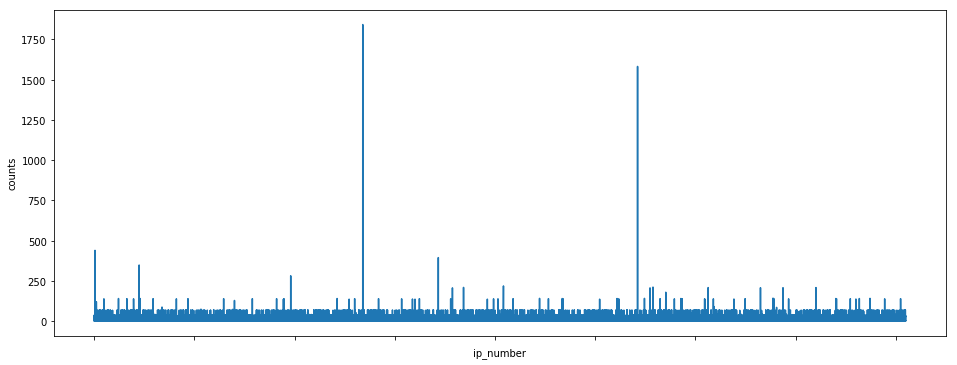

In [15]:
## We will try to find another anomaly - number of login attempts from the same ip in an interval of one minute
# lets check the histogram of the ips
unique_ips = data["socket_ip"].unique()
print("the number of unique ips is : " + str(unique_ips.shape[0]))
ip_hist = data["socket_ip"].value_counts(sort=False)
plt.figure(figsize=(16, 6))
ip_hist.plot()
plt.xlabel("ip_number")
plt.ylabel("counts")


In [16]:
# There are clearly some ips that try to login more than others
# We will calculate the maximum number of login attempts in one minute for each ip
ips_max_login = pd.DataFrame(index = unique_ips, columns=["max_login_per_minute"])
for ip in unique_ips:
    ip_data = data[data["socket_ip"] == ip]
    bin_range = pd.date_range(ip_data["f0_"].iloc[0], ip_data["f0_"].iloc[-1] + pd.Timedelta(minutes=1), freq="1min")
    f0_hist, _ = pd.cut(ip_data["f0_"], bins=bin_range, include_lowest=True, right=False, retbins=True)
    ips_max_login.loc[ip] = f0_hist.value_counts().max()


In [18]:
## Lets look at the percentiles of maximum logins in one minute for each ip
ips_max_login = ips_max_login.sort_values("max_login_per_minute")
max_ip_login_percentiles = ips_max_login.describe(percentiles=np.arange(0.01, 1, 0.0001)).iloc[4:-1]
print(max_ip_login_percentiles)

                   max_login_per_minute
1%                               1.0000
1.01%                            1.0000
1.02%                            1.0000
1.03%                            1.0000
1.04%                            1.0000
1.05%                            1.0000
1.06%                            1.0000
1.07%                            1.0000
1.08%                            1.0000
1.09%                            1.0000
1.1%                             1.0000
1.11%                            1.0000
1.12%                            1.0000
1.13%                            1.0000
1.14%                            1.0000
1.15%                            1.0000
1.16%                            1.0000
1.17%                            1.0000
1.18%                            1.0000
1.19%                            1.0000
1.2%                             1.0000
1.21%                            1.0000
1.22%                            1.0000
1.23%                            1.0000


In [25]:
## we can see that 99.9699% of the ips have a maximum number of login attempts per one minute
#  less than 20. This could be a good threshold to detect an anomaly of an ip that is trying
#  to login too many times in one minute
max_logins_by_ip_threshold = 20
print("The following ips have significant greater maximum amount of login attempts per minute than others: ")
print(list(ips_max_login[ips_max_login["max_login_per_minute"]>max_logins_by_ip_threshold].index))


The following ips have significant maximum amount of login attempts per minute than others: 
['132.3.13.80', '130.18.104.170', '209.17.114.78', '157.48.5.71', '52.73.39.35']
